In [1]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.optimize import fsolve
from graph import *
from tqdm import tqdm

(34, 75) 75
(75, 75)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(34, 75)
34 75
{'29.txt': array([ 0.14597748, -0.09201841]), '28.txt': array([-0.11582374, -0.01862393]), 'out_text_1912.txt': array([0.48721037, 0.60851545]), 'cia.txt': array([-0.74551031, -0.366272  ]), 'out_text_1901.txt': array([ 1.        , -0.54477827]), 'out_text_1902.txt': array([0.48451935, 0.3905298 ]), '5.txt': array([-0.72182487, -0.16414364]), '4.txt': array([ 0.21247419, -0.21317312]), '6.txt': array([-0.88277679,  0.60951169]), '7.txt': array([-0.70004971, -0.3378838 ]), 'out_text_1909.txt': array([0.42695568, 0.53654284]), 'out_text_1908.txt': array([-0.98966034,  0.26515823]), '0.txt': array([0.35007928, 0.3210384 ]), '19650.txt': array([-0.26993448, -0.61230205]), '1.txt': array([0.29068053, 0.00956771]), '35.txt': array([0.17676115, 0.16764972]), '23.txt': array([-0.02866944,  0.31521736]), '

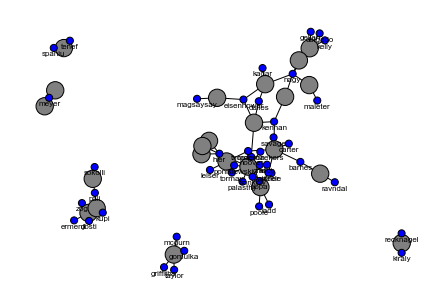

In [31]:
# %load graph.py
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def make_adjacency_matrix(M, names):
    n = len(names)
    print(M.shape, n)
    A = np.zeros(n * n)
    A = A.reshape((n,n))
    print(A.shape)
    for doc in M:
        for i in range(n):
            if doc[i] != 0:
                for j in range(i+1, len(doc)):
                    if doc[j] != 0:
                        A[i][j] += 1
                        A[j][i] += 1
    print(A)
    return A


def nx_graph_from_adjacency_matrix(M, names):
    print(M.shape)
    V = names
    print(len(V))

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(V, nodetype="green")

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (V[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # remove isolated nodes
    deg = G.degree()
    to_remove = [n[0] for n in deg if n[1] == 0]
    G.remove_nodes_from(to_remove)
    
    # formatting
    nx.draw(G, font_size=5, node_size=7, with_labels=True)
    plt.show()
    return G

# makes bipartite graph from documents to people
def nx_graph_from_biadjacency_matrix(M, txtfiles, names):
    print(M.shape)

    U = txtfiles
    V = names
    print(len(U), len(V))

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0, nodetype="grey", nodesize=300, nodelabel=False)
    G.add_nodes_from(V, bipartite=1, nodetype="blue", nodesize=50, nodelabel=True)

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (U[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # remove isolated nodes
    deg = G.degree()
    to_remove = [n[0] for n in deg if n[1] == 0]
    G.remove_nodes_from(to_remove)
    
    # formatting
    colors = [u[1] for u in G.nodes(data="nodetype")]
    sizes = [u[1] for u in G.nodes(data="nodesize")]
    labels = [u[1] for u in G.nodes(data="nodelabel")]
    pos = nx.spring_layout(G, seed=101)
    nx.draw(G, pos=pos, node_size = sizes, with_labels=False, node_color = colors, edgecolors='black')

    print(pos)
    textPos = pos.copy()
    for k in textPos:
        textPos[k][1] -= .035
        pass

    labels = {}    
    for node in G.nodes():
        if ".txt" not in node:
            #set the node name as the key and the label as its value 
            labels[node] = node
    nx.draw_networkx_labels(G, textPos, labels, font_size=8, font_family="arial")

    plt.show()
    return G


if __name__ == "__main__":
    filename = 'frequency.csv'
    df = pd.read_csv(filename)
    mydata = genfromtxt(filename, delimiter=',')
    mydata = mydata[1:,1:]

    names = list(df.columns)[1:]
    txtfiles = list(df["id"])

    # nx_graph_from_biadjacency_matrix(mydata, txtfiles, names)

    A = make_adjacency_matrix(mydata, names)
    #nx_graph_from_adjacency_matrix(A, names)
    nx_graph_from_biadjacency_matrix(mydata, txtfiles, names)





In [32]:
(names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
basemat = make_adjacency_matrix(basedata, names)
(baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 1)

NameError: name 'getfreqmatrix' is not defined